<a href="https://colab.research.google.com/github/martosdomo/smvae/blob/main/VAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

* Import packages
* Hyperparameters
* Import dataset & augment with contrast



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from math import exp
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import Tensor
from torchvision import transforms
from torchvision.utils import make_grid
from torch.distributions.gamma import Gamma
from torch.distributions.normal import Normal

from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

from google.colab import files

import statsmodels.api as sm

from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.insert(0,'/content/gdrive/My Drive/Colab Notebooks/modules')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
print('hello world')

In [ ]:
# CONTRAST FUNCTIONS

def fixed_contrast(data, c_list):
    new_data = []
    for img, label in data:
        for c in c_list:
            img_aug = img * c
            new_data.append((img_aug, label))
    return new_data

def random_contrast(data, min_contrast, max_contrast,
                    digit_instances, length):
    new_data = []
    size = 0

    for img, label in data:
        for i in range(digit_instances):
            c = random.uniform(min_contrast, max_contrast)
            c = round(c, 4)
            img_aug = img * c
            new_data.append((img_aug, (label, c)))
            size += 1
            if size >= length:
                return new_data
    return new_data

# CREATE TEST & TRAIN SETS

def create_trainset(digit_instances, length,
                    min_contrast, max_contrast):
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    trainset = random_contrast(trainset, min_contrast, max_contrast,
                               digit_instances, length)
    #trainset = trainset[:length]

    return trainset

def create_testset(digit_instances, min_contrast=0, max_contrast=1):
    transform = transforms.Compose([transforms.ToTensor()])
    testset = datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )
    testset = random_contrast(testset, min_contrast, max_contrast, digit_instances, 200000)

    return testset

# Hyperparameters & test-train-sets


In [ ]:
# HYPERPARAMETERS

LATENT_SIZE = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.5*1e-3
NUM_EPOCHS = 15

random_seed = 1
is_bce = True

In [ ]:
random.seed(random_seed)

digit_inst = 4
length = 24000
min_contrast = 0
max_contrast = 1

trainset = create_trainset(digit_inst, length, min_contrast, max_contrast)
testset = create_testset(digit_inst)

trainloader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
testloader = DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Classes
* Vanillia VAE with Encoder and Decoder subclasses
* SMVAE (prior: normal, lognormal, gamma)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_sizes, latent_size, nonlinearity):
        super(Encoder, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.input_size = input_size
        self.latent_size = latent_size
        self.nonlinearity = nonlinearity

        # Layers
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))

        for i in range(len(hidden_sizes)-1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.fc_mean = nn.Linear(hidden_sizes[-1], latent_size)
        self.fc_logvar = nn.Linear(hidden_sizes[-1], latent_size)


    def forward(self, x):
        x = x.view(-1, self.input_size)
        for layer in self.hidden_layers:
            x = self.nonlinearity(layer(x))

        z_mean = self.fc_mean(x)
        z_logvar = self.fc_logvar(x)

        return z_mean, z_logvar

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_sizes, output_size, nonlinearity):
        super(Decoder, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.latent_size = latent_size
        self.nonlinearity = nonlinearity

        # layers
        self.hidden_layers.append(nn.Linear(latent_size, hidden_sizes[0]))
        for i in range(len(hidden_sizes)-1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, z):
        for layer in self.hidden_layers:
            z = self.nonlinearity(layer(z))

        x_recon = torch.sigmoid(self.output_layer(z))

        return x_recon


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_size, enc_hidden_sizes, dec_hidden_sizes, latent_size, enc_nonlinearity=nn.ReLU(), dec_nonlinearity=nn.ReLU()):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, enc_hidden_sizes, latent_size, enc_nonlinearity)
        self.decoder = Decoder(latent_size, dec_hidden_sizes, input_size, dec_nonlinearity)
        self.latent_size = latent_size
        self.name = 'Standard VAE'
        self.loss = (0,0,0)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        self.var = std
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        #c = torch.sqrt(torch.sum(torch.square(z)))
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

    def loss_function(self, x_recon, x, mu, logvar, is_bce):
        KLD = -0.5 * torch.sum((self.latent_size + torch.sum(logvar - mu.pow(2) - logvar.exp(), dim=1)))
        if is_bce:
            REC = F.binary_cross_entropy(x_recon, x.view(-1, 784), reduction='sum')
        else:
            REC = F.mse_loss(x_recon, x.view(-1, 784), reduction='sum')
        self.loss = REC + KLD, REC, KLD
        return self.loss

    def loss_function_CB(self, x_recon, x, mu, logvar):
        KLD = -0.5 * torch.sum((self.latent_size + torch.sum(logvar - mu.pow(2) - logvar.exp(), dim=1)))
        x = x.view(-1, 784)
        CBCE = -torch.sum(x*x_recon.log() + (1-x)*(1-x_recon).log() + C(x_recon).log())
        return CBCE + KLD, CBCE, KLD

In [ ]:
class SMVAE_NORMAL(nn.Module):
    def __init__(self, input_size, enc_hidden_sizes, dec_hidden_sizes, latent_size, enc_nonlinearity=nn.ReLU(), dec_nonlinearity=nn.ReLU()):
        super(SMVAE_NORMAL, self).__init__()
        self.encoder = Encoder(input_size, enc_hidden_sizes, latent_size, enc_nonlinearity)
        self.decoder = Decoder(latent_size-1, dec_hidden_sizes, input_size, dec_nonlinearity)
        self.input_size = input_size
        self.enc_hidden_sizes = enc_hidden_sizes
        self.dec_hidden_sizes = dec_hidden_sizes
        self.latent_size = latent_size
        self.name = 'post c-Normál VAE'
        self.loss = (0,0,0)

    def reparameterize(self, mean, logvar):
        var = torch.exp(0.5 * logvar)
        d = Normal(mean, var)
        z = d.rsample()
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        l = self.reparameterize(mu, logvar) # l.size() = batch_size * latent_size
        z = l[:, :self.latent_size-1] # z az első n-1 látens dim.
        c = l[:, self.latent_size-1]  # c az utolsó dimenzió
        c = c.reshape(BATCH_SIZE, 1)
        x_recon = self.decoder(c*z)
        return x_recon, mu, logvar

    def loss_function(self, x_recon, x, mu, logvar, is_bce):
        KLD = -0.5 * torch.sum((self.latent_size + torch.sum(logvar - mu.pow(2) - logvar.exp(), dim=1)))
        if is_bce:
            REC = F.binary_cross_entropy(x_recon, x.view(-1, 784), reduction='sum')
        else:
            REC = F.mse_loss(x_recon, x.view(-1, 784), reduction='sum')
        self.loss = REC + KLD, REC, KLD
        return self.loss

In [ ]:
class SMVAE_LOGNORMAL(nn.Module):
    def __init__(self, input_size, enc_hidden_sizes, dec_hidden_sizes, latent_size, enc_nonlinearity=nn.ReLU(), dec_nonlinearity=nn.ReLU()):
        super(SMVAE_LOGNORMAL, self).__init__()
        self.encoder = Encoder(input_size, enc_hidden_sizes, latent_size, enc_nonlinearity)
        self.decoder = Decoder(latent_size-1, dec_hidden_sizes, input_size, dec_nonlinearity)
        self.input_size = input_size
        self.enc_hidden_sizes = enc_hidden_sizes
        self.dec_hidden_sizes = dec_hidden_sizes
        self.latent_size = latent_size
        self.name = 'post c-logNormál VAE'
        self.loss = (0,0,0)

    def reparameterize(self, mean, logvar):
        var = torch.exp(0.5 * logvar)
        d = Normal(mean, var)
        z = d.rsample()
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        l = self.reparameterize(mu, logvar) # l.size() = batch_size * latent_size
        z = l[:, :self.latent_size-1] # z az első n-1 látens dim.
        c = l[:, self.latent_size-1]  # c az utolsó dimenzió
        c = c.reshape(-1, 1)
        c = torch.exp(c)
        #c = torch.sigmoid(c)
        x_recon = self.decoder(z)
        x_recon = x_recon*c
        x_recon = torch.clamp(x_recon, max=1)
        return x_recon, mu, logvar

    def loss_function(self, x_recon, x, mu, logvar, is_bce):
        KLD = -0.5 * torch.sum((self.latent_size + torch.sum(logvar - mu.pow(2) - logvar.exp(), dim=1)))
        if is_bce:
            REC = F.binary_cross_entropy(x_recon, x.view(-1, 784), reduction='sum')
        else:
            REC = F.mse_loss(x_recon, x.view(-1, 784), reduction='sum')
        self.loss = REC + KLD, REC, KLD
        return self.loss

In [ ]:
class SMVAE_GAMMA(nn.Module):
    def __init__(self, input_size, enc_hidden_sizes, dec_hidden_sizes, latent_size, a, enc_nonlinearity=nn.ReLU(), dec_nonlinearity=nn.ReLU()):
        super(SMVAE_GAMMA, self).__init__()
        self.encoder = Encoder(input_size, enc_hidden_sizes, latent_size, enc_nonlinearity)
        self.decoder = Decoder(latent_size-1, dec_hidden_sizes, input_size, dec_nonlinearity)
        self.input_size = input_size
        self.enc_hidden_sizes = enc_hidden_sizes
        self.dec_hidden_sizes = dec_hidden_sizes
        self.latent_size = latent_size
        self.name = 'Gamma(' + str(a) + ') SMVAE'
        self.a = a
        self.loss = (0,0,0)

    def get_params(self, mean, var):
        mu = mean[:,:-1]
        sigma = torch.exp(0.5 * var[:,:-1])
        logvar = var[:,:-1]

        g_logmean = mean[:,-1]
        g_logvar = var[:,-1]
        alpha = torch.exp(g_logmean)**2 / torch.exp(g_logvar)
        beta = torch.exp(g_logmean) / torch.exp(g_logvar)

        return mu, sigma, logvar, alpha, beta

    def reparameterize(self, mu, sigma, alpha, beta):
        z = Normal(mu, sigma).rsample()
        c = Gamma(alpha, beta).rsample()#.unsqueeze(dim=0) # EZ ÍGY MŰKÖDIK?

        return z, c

    def forward(self, x):
        mean, var = self.encoder(x)
        mu, sigma, logvar, alpha, beta = self.get_params(mean, var)

        z, c = self.reparameterize(mu, sigma, alpha, beta) # l.size() = batch_size * latent_size
        c = c.reshape(BATCH_SIZE, 1)
        x_recon = self.decoder(z*c)
        #x_recon = x_recon*c
        #print(torch.max(x_recon))
        #x_recon = torch.clamp(x_recon, max=1)
        return x_recon, mean, var

    # gamma prior legyen (alpha,1)
    def loss_function(self, x_recon, x, mean, var, is_bce):
        prior_alpha = Tensor([self.a])
        prior_beta = Tensor([1])

        mu, sigma, logvar, alpha, beta = self.get_params(mean, var)

        KL_normal = -0.5 * torch.sum((self.latent_size + torch.sum(logvar - mu.pow(2) - logvar.exp(), dim=1)))

        KL_gamma = torch.sum(\
                   (alpha-prior_alpha)*torch.digamma(alpha) \
                 - (beta-prior_beta)*alpha/beta \
                 + alpha*torch.log(beta) \
                 + torch.lgamma(prior_alpha) \
                 - torch.lgamma(alpha))

        #print('normal: ', KL_normal, ', gamma: ', KL_gamma)

        KLD = KL_normal + KL_gamma
        if is_bce:
            REC = F.binary_cross_entropy(x_recon, x.view(-1, 784), reduction='sum')
        else:
            REC = F.mse_loss(x_recon, x.view(-1, 784), reduction='sum')
        self.loss = REC + KLD, REC, KLD
        return self.loss

# Functions
* loss functions
* train function
* plot - *plot training*
* grid - *exploring latent space*
* compare - *compare reconstructed images with the original*
* get_avereges - *a különböző kontrasztokra vett posterior átlagok kigyűjtése*
* barplot - *barchart a különböző kontrasztokra vett posteriorokra*
* elbo - elbo számolása a testset-en



In [ ]:
def train(model, is_bce, epochs=NUM_EPOCHS):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_reconstr = 0.0
        running_regul = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            optimizer.zero_grad()
            x_recon, mu, logvar = model(inputs)
            #print(mu, logvar) # WORKING
            loss, reconstr, regul = model.loss_function(x_recon, inputs, mu, logvar, is_bce)
            #print('loss: ', loss, reconstr, regul)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_reconstr += reconstr
            running_regul += regul
        epoch_loss = running_loss/len(trainset)
        epoch_reconstr = running_reconstr/len(trainset)
        epoch_regul = running_regul/len(trainset)
        losses.append([epoch_loss, epoch_reconstr.detach().numpy(), epoch_regul.detach().numpy()])

        print('Epoch [%d/%d], Loss: %.3f, Reconstruction: %.3f, Regularization: %.3f'
              % (epoch+1, epochs, epoch_loss, epoch_reconstr, epoch_regul))
    return losses

In [ ]:
def plot(data, str='Title'):
    plt.figure()
    plt.plot(data)
    plt.title(str)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [ ]:
def grid(model, coordinates, rows=20, cols=20, title='Title'):
    #x = y = np.linspace(-range, range, resolution)
    #grid = torch.tensor([[i, j, k] for i in x for j in y])
    grid = torch.tensor(coordinates)
    grid = grid.to(torch.float32)
    samples = model.decoder(grid)
    samples = samples.view(rows*cols, 1, 28, 28)
    grid = make_grid(samples, nrow=cols, normalize=True)

    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.show()

In [ ]:
def compare(model, n, k=0, title='Title'):
    og = [testset[i+k][0].reshape(28,28) for i in range(n)]
    rec = [model(testset[i+k][0])[0][0].detach().numpy().reshape(28,28) for i in range(n)]

    fig, ax = plt.subplots(2, n, figsize=(n,3))
    fig.suptitle(title)
    ax[0, 0].set_title('Eredeti')
    ax[1, 0].set_title('Rekonstruált')
    for i in range(n):
      ax[0, i].imshow(og[i], cmap='gray', vmax=1)
      ax[1, i].imshow(rec[i], cmap='gray', vmax=1)

    plt.show()

In [ ]:
def barplot(data, ylabel='ylabel', title='Title'):
    z1_group = data[:,0].detach().numpy().flatten()
    z2_group = data[:,1].detach().numpy().flatten()
    c_group = data[:,2].detach().numpy().flatten()

    axis_labels = ['c = ' + str(contrast_values[i]) for i in range(4)]

    positions = np.array([i for i in range(0, 13, 4)])
    z1_pos = positions
    z2_pos = positions + 1
    c_pos = positions + 2

    fig, ax = plt.subplots()

    plt.bar(z1_pos, z1_group, label='$z_1$', color='forestgreen')
    plt.bar(z2_pos, z2_group, label='$z_2$', color='limegreen')
    plt.bar(c_pos, c_group, label='$c$', color='r')

    # Assigning group labels to the x-axis
    plt.xticks([1+4*d for d in range(4)], axis_labels)

    # Adding legend
    plt.legend()

    plt.grid(axis='y')
    ax.set_axisbelow(True)

    # Display the bar chart
    plt.xlabel('Kontraszt értékek')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [ ]:
def get_avereges(model):

    # PARAMS
    n = 10000
    contrasts = len(contrast_values)
    post_sum = torch.zeros(4, 2, LATENT_SIZE)
    dif_chars = n // contrasts

    # REGRESSION DATA
    cs = torch.zeros(n)
    means = torch.zeros(n,LATENT_SIZE)
    vars = torch.zeros(n,LATENT_SIZE)
    #means = vars = torch.zeros(n, LATENT_SIZE)

    # GET POSTERIOR AVEREGES AND REGRESSION DATA

    for i in range(0, n, contrasts):
        for c in range(contrasts):
            # mean
            # post_sum[c][0]: c a megfelelő kontraszt, 0 a mean értékek
            # encoder[0][0]: 0 a mean érték, második 0 a grad info elhagyása
            mean = model.encoder(testset[i+c][0])[0][0]
            #mean[2] = torch.exp(mean[2])

            # var
            logvar = model.encoder(testset[i+c][0])[1][0]
            var = torch.exp(0.5*logvar)
            #var[2] = torch.exp(var[2])

            # for lognormal
            """mean_logn = torch.exp(mean[2] + var[2]**2/2)
            var_logn = torch.sqrt(torch.exp(2*mean[2] + 2*var[2]**2) - torch.exp(2*mean[2] + var[2]**2))
            mean[2] = mean_logn
            var[2] = var_logn"""

            # for gamma
            mean[2] = torch.exp(mean[2])

            post_sum[c][0] += mean
            post_sum[c][1] += var

            # REGRESSION DATA
            cs[i+c] = contrast_values[c]
            means[i+c] = mean#[2]
            vars[i+c] = var#[2]

    post_mean = post_sum / dif_chars

    return post_mean, cs, means, vars

In [ ]:
def ELBO(model, is_bce):
    running_loss = 0.0
    running_reconstr = 0.0
    running_regul = 0.0
    for input in testset:
        x_recon, mu, logvar = model(input[0])
        loss, reconstr, regul = model.loss_function(x_recon, input[0], mu, logvar, is_bce)
        running_loss += loss
        running_reconstr += reconstr
        running_regul += regul
    epoch_loss = running_loss / len(testset)
    epoch_reconstr = running_reconstr / len(testset)
    epoch_regul = running_regul / len(testset)

    return epoch_loss, epoch_reconstr, epoch_regul

# Model creation and training
* various models with different size and (non)linearity

In [ ]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

enc_layers = [256, 32]
dec_layers = [32, 256]

model_vae = VAE(784, enc_layers, dec_layers, LATENT_SIZE, nn.ReLU(), nn.ReLU())

model_normal = SMVAE_NORMAL(784, enc_layers, dec_layers, LATENT_SIZE, nn.ReLU(), nn.ReLU())
model_lognormal = SMVAE_LOGNORMAL(784, enc_layers, dec_layers, LATENT_SIZE, nn.ReLU(), nn.ReLU())
model_gamma = SMVAE_GAMMA(784, enc_layers, dec_layers, LATENT_SIZE, a = 1)

Epoch [1/10], Loss: 212.728, Reconstruction: 210.553, Regularization: 2.175
Epoch [2/10], Loss: 135.357, Reconstruction: 132.265, Regularization: 3.093
Epoch [3/10], Loss: 128.293, Reconstruction: 124.188, Regularization: 4.106
Epoch [4/10], Loss: 124.105, Reconstruction: 119.420, Regularization: 4.685
Epoch [5/10], Loss: 120.920, Reconstruction: 115.767, Regularization: 5.152
Epoch [6/10], Loss: 117.947, Reconstruction: 112.250, Regularization: 5.698
Epoch [7/10], Loss: 115.554, Reconstruction: 109.243, Regularization: 6.311
Epoch [8/10], Loss: 114.165, Reconstruction: 107.586, Regularization: 6.579
Epoch [9/10], Loss: 113.039, Reconstruction: 106.283, Regularization: 6.756
Epoch [10/10], Loss: 112.056, Reconstruction: 105.106, Regularization: 6.950
Epoch [1/10], Loss: 1706.755, Reconstruction: 1703.464, Regularization: 3.290
Epoch [2/10], Loss: 185.015, Reconstruction: 181.908, Regularization: 3.108
Epoch [3/10], Loss: 140.617, Reconstruction: 137.074, Regularization: 3.543
Epoch [4/

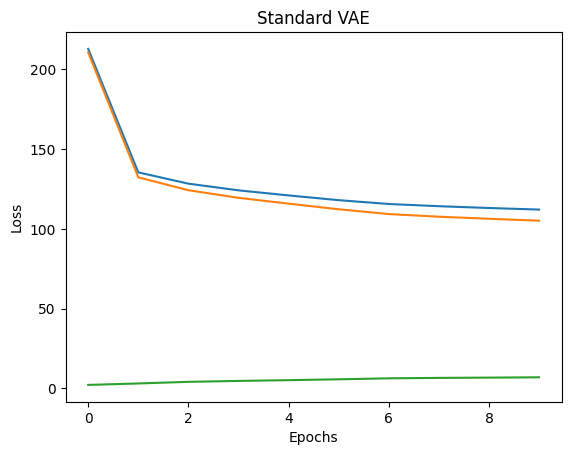

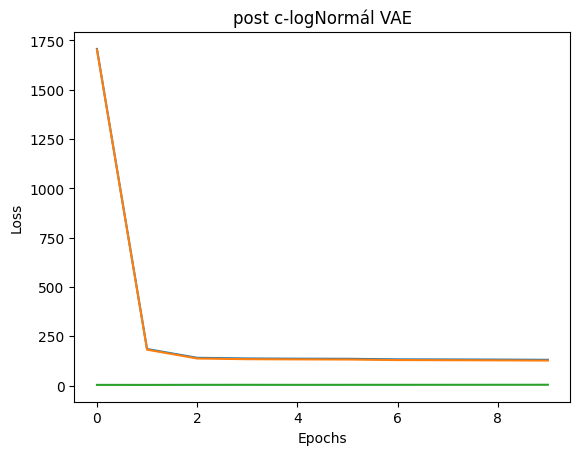

In [ ]:
#model = model_lognormal
NUM_EPOCHS = 10
myloss = train(model_vae, is_bce, NUM_EPOCHS)
myloss2 = train(model_lognormal, is_bce, NUM_EPOCHS)

plot(myloss, model_vae.name)
plot(myloss2, model_lognormal.name)

# Save model

In [ ]:
model = model_lognormal
#(self, input_size, enc_hidden_sizes, dec_hidden_sizes, latent_size, enc_nonlinearity=nn.ReLU(), dec_nonlinearity=nn.ReLU()):
#SMVAE_NORMAL(784, [256, 32], [32, 256], LATENT_SIZE, nn.ReLU(), nn.ReLU())
'''checkpoint = {'input_size': model.input_size,
              'enc_hidden_sizes': model.enc_hidden_sizes,
              'dec_hidden_sizes': model.dec_hidden_sizes,
              'latent_size': model.latent_size,
              'state_dict': model.state_dict()}'''

checkpoint = {'input_size': 784,
              'enc_hidden_sizes': [256, 32],
              'dec_hidden_sizes': [32, 256],
              'latent_size': model.latent_size,
              'state_dict': model.state_dict()}

savename = 'smvae_rand4_60_0.8_1.pth'

torch.save(checkpoint, savename)
files.download(savename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load model
* *a CLASS nevét megfelelőre kell állítani!*


In [ ]:
# a CLASS nevét megfelelőre kell állítani

def load_checkpoint_standard(filepath):
    checkpoint = torch.load(filepath)
    model = VAE(checkpoint['input_size'],
                                checkpoint['enc_hidden_sizes'],
                                checkpoint['dec_hidden_sizes'],
                                checkpoint['latent_size'])
    model.load_state_dict(checkpoint['state_dict'])

    return model

def load_checkpoint_normal(filepath):
    checkpoint = torch.load(filepath)
    model = SMVAE_NORMAL(checkpoint['input_size'],
                                checkpoint['enc_hidden_sizes'],
                                checkpoint['dec_hidden_sizes'],
                                checkpoint['latent_size'])
    model.load_state_dict(checkpoint['state_dict'])

    return model

def load_checkpoint_normal_exp(filepath):
    checkpoint = torch.load(filepath)
    model = SMVAE_LOGNORMAL(checkpoint['input_size'],
                                checkpoint['enc_hidden_sizes'],
                                checkpoint['dec_hidden_sizes'],
                                checkpoint['latent_size'])
    model.load_state_dict(checkpoint['state_dict'])

    return model

def load_checkpoint_gamma(filepath, a):
    checkpoint = torch.load(filepath)
    model = SMVAE_GAMMA(checkpoint['input_size'],
                                checkpoint['enc_hidden_sizes'],
                                checkpoint['dec_hidden_sizes'],
                                checkpoint['latent_size'],
                                a)
    model.load_state_dict(checkpoint['state_dict'])

    return model

In [ ]:
model_standard = load_checkpoint_standard('/content/standard_20E.pth')
model_normal = load_checkpoint_normal('/content/normal_20E.pth')
model_lognormal = load_checkpoint_normal_exp('/content/post_lognormal_20E.pth')
model_gamma1 = load_checkpoint_gamma('/content/gamma1_20E.pth', 1)
model_gamma3 = load_checkpoint_gamma('/content/gamma3_20E.pth', 3)

In [ ]:
#model = load_checkpoint_gamma('/content/normal_20E.pth', 5)
model = load_checkpoint('/content/standard_20E.pth')
#model2 = load_checkpoint('/content/contrast_normal_exp_10E.pth')
print(model)
type(model)
model.name, model.loss

VAE(
  (encoder): Encoder(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=32, bias=True)
    )
    (nonlinearity): ReLU()
    (fc_mean): Linear(in_features=32, out_features=3, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=256, bias=True)
    )
    (nonlinearity): ReLU()
    (output_layer): Linear(in_features=256, out_features=784, bias=True)
  )
)


('Standard VAE', (0, 0, 0))

# Visual analysis

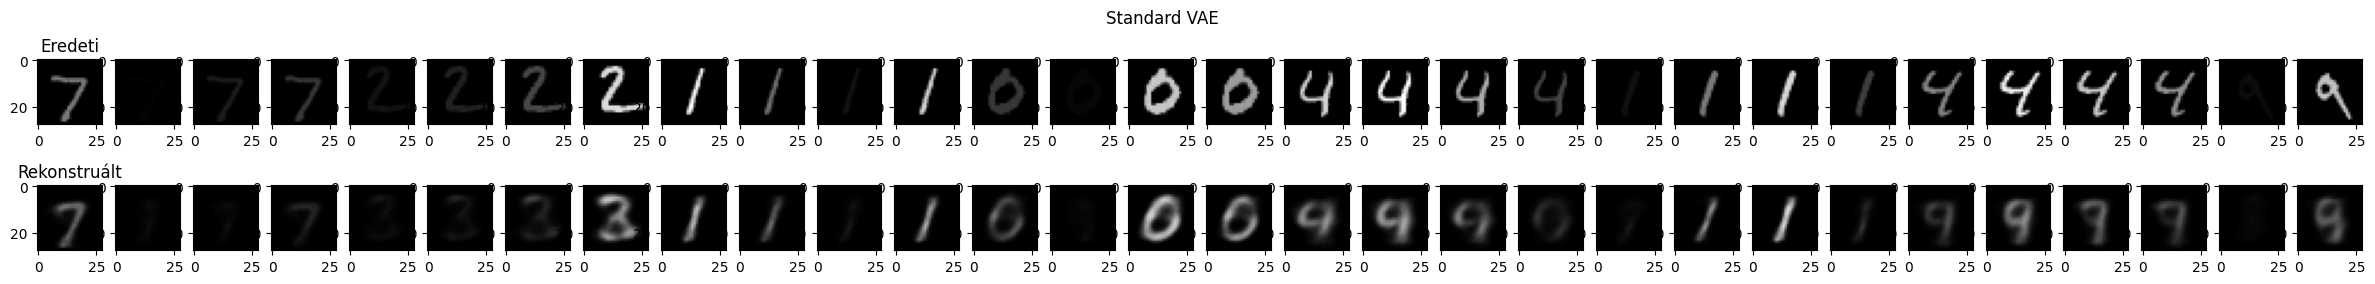

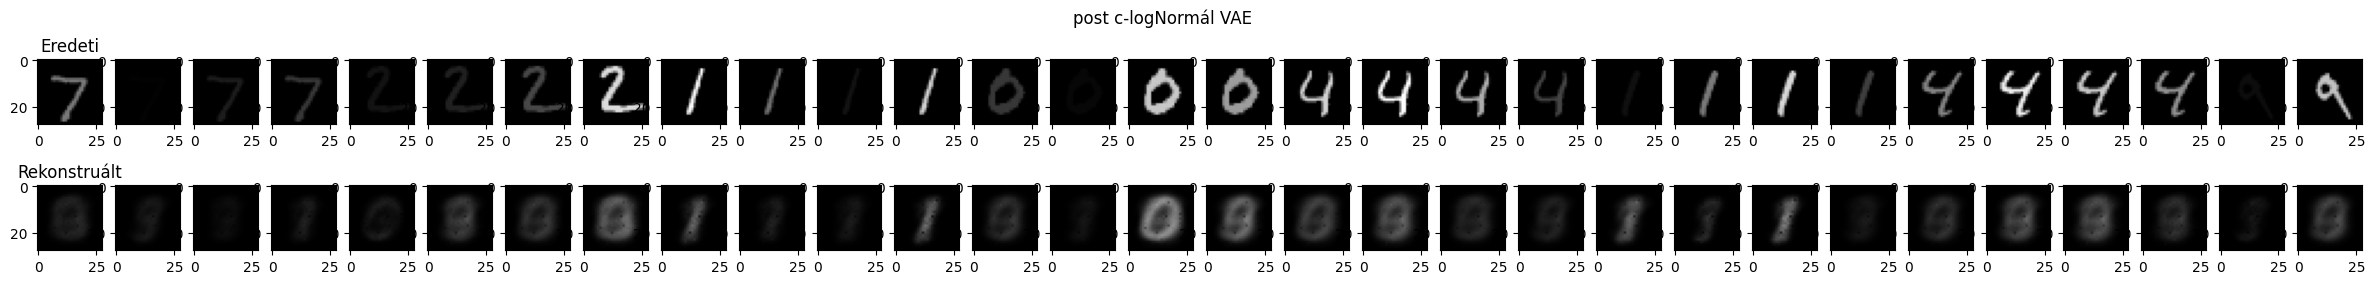

In [ ]:
BATCH_SIZE = 1
model = model_vae
compare(model, 30, title=model.name)
model = model_lognormal
compare(model, 30, title=model.name)
BATCH_SIZE = 128

In [ ]:
#z = torch.randn(64, LATENT_SIZE)
#samples = model.decoder(z)
x = torch.tensor(trainset[0][0])
plt.imshow(x.view(28,28), vmax=1)
#samples = model(x)
#samples = samples.view(64, 1, 28, 28)
#plt.imshow(samples[0].view(28,28).detach().numpy())

# Quantitative analysis

In [ ]:
post_mean, cs, means, vars = get_avereges(model)

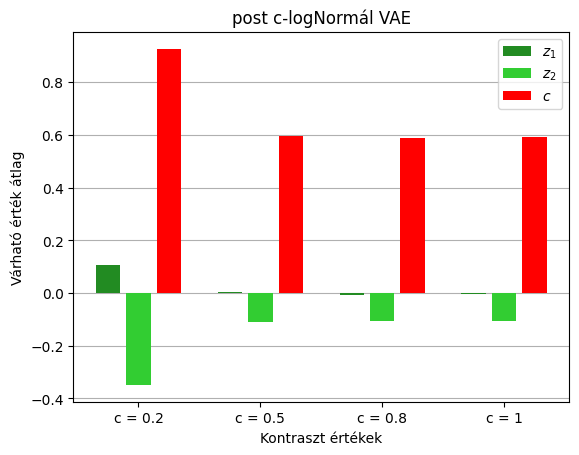

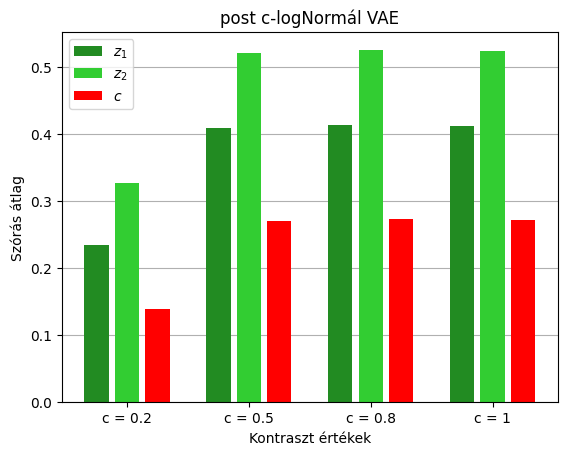

In [ ]:
mean_chart = post_mean[:,0]
var_chart = post_mean[:,1]

barplot(mean_chart, 'Várható érték átlag', model.name)
barplot(var_chart, 'Szórás átlag', model.name)

In [ ]:
correlation = np.corrcoef(cs.detach().numpy(), means.detach().numpy())[0, 1]

# Print the correlation coefficient
print("Correlation coefficient:", correlation)

Correlation coefficient: 0.07426734344612182


In [ ]:
# LINEAR REGRESSION
# erre fix lehetne egy fv.

x = cs.numpy()  # independent variable
y = means.detach().numpy() # dependent variable

# Add a constant term to the independent variable

# EZ KELL?????
x = sm.add_constant(x)

# Create a linear regression model
regr = sm.OLS(y, x)

# Fit the model
results = regr.fit()

# Print the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     324.9
Date:                Mon, 22 May 2023   Prob (F-statistic):           1.67e-71
Time:                        13:00:06   Log-Likelihood:                -20677.
No. Observations:               10000   AIC:                         4.136e+04
Df Residuals:                    9998   BIC:                         4.137e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5249      0.044     11.970      0.0

# Compare ELBO


In [ ]:
BATCH_SIZE = 1
#models = [model_standard, model_normal, model_lognormal, model_gamma1, model_gamma3]
models = [model_vae, model_lognormal]

for m in models:
  elbou = ELBO(m, is_bce)
  print('ELBO ' + m.name + ': ' + str(elbou))

BATCH_SIZE = 128

ELBO Standard VAE: (tensor(112.9028, grad_fn=<DivBackward0>), tensor(105.7877, grad_fn=<DivBackward0>), tensor(7.1154, grad_fn=<DivBackward0>))
ELBO post c-logNormál VAE: (tensor(132.4521, grad_fn=<DivBackward0>), tensor(128.3188, grad_fn=<DivBackward0>), tensor(4.1338, grad_fn=<DivBackward0>))
